# Tiny example for SARIMA forecasting
This exercise contains a SARIMA prediction and forecast on California Hospitality Industry Employees dataset from Jan 1990-Dec 2018 (348 records) Source: https://fred.stlouisfed.org/series/CALEIHN

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf   #for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose         #for ETS Plots
from pmdarima import auto_arima

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

import warnings
warnings.filterwarnings("ignore")

c:\Users\bahao\anaconda3\envs\TimeSeries\lib\site-packages\sklearn\utils\validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


In [2]:
df = pd.read_csv('Data/HospitalityEmployees.csv', index_col='Date', parse_dates=True)
df.index.freq = 'MS'

print(df.head())

            Employees
Date                 
1990-01-01     1064.5
1990-02-01     1074.5
1990-03-01     1090.0
1990-04-01     1097.4
1990-05-01     1108.7


### 1. Plot the data

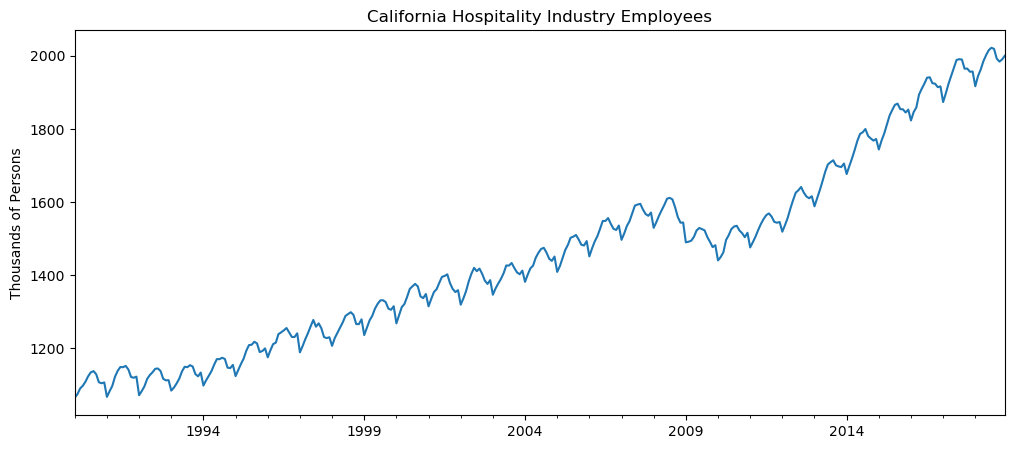

In [3]:
title = 'California Hospitality Industry Employees'
ylabel = 'Thousands of Persons'
xlabel = ''


ax = df['Employees'].plot(figsize= (12,5), title = title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### 2. ETS Decomposition

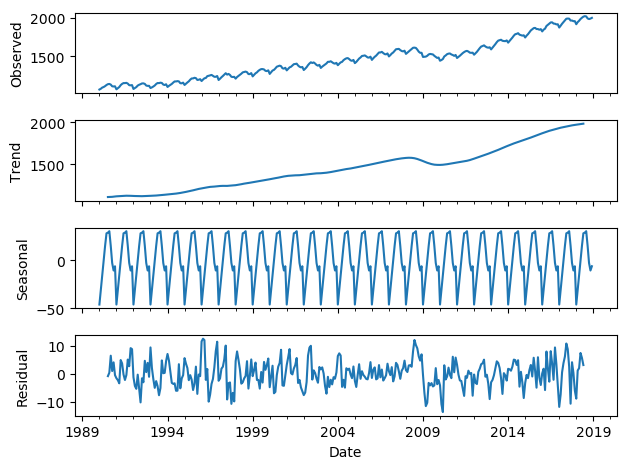

In [4]:
result = seasonal_decompose(df['Employees'], model = 'add')
result.plot();

### 3. Run <tt>pmdarima.auto_arima</tt> to obtain recommendations

In [5]:
auto_arima(df['Employees'], seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  348
Model:             SARIMAX(0, 1, 0)x(2, 0, 0, 12)   Log Likelihood               -1134.664
Date:                            Tue, 20 Sep 2022   AIC                           2277.328
Time:                                    00:50:38   BIC                           2292.726
Sample:                                         0   HQIC                          2283.459
                                            - 348                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0477      0.292     -0.163      0.870      -0.620       0.524
ar.S.L12       0.5291      0.040     13.286      0.000       0.451       0.607
ar.S.L24       0.4303      0.041     10.453      0.000       0.350       0.511
sigma2        37.2952      2.157     17.294      0.000      33.068      41.522
===================================================================================
Ljung-Box (Q):                       99.53   Jarque-Bera (JB):                51.67
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.29
Prob(H) (two-sided):                  0.42   Kurtosis:                         4.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 4. Train/test split
Let's set one year (12 records) for testing. It's around 3% test data

In [6]:
train = df.iloc[:len(df)-12]
test = df.iloc[len(df)-12:] 

### 5. Creating SARIMA(0,1,0)(2,0,0,12) model and fit the model

In [7]:
model = SARIMAX(train['Employees'], order=(0,1,0), seasonal_order=(2,0,0,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          Employees   No. Observations:                  336
Model:             SARIMAX(0, 1, 0)x(2, 0, 0, 12)   Log Likelihood               -1095.407
Date:                            Tue, 20 Sep 2022   AIC                           2196.814
Time:                                    00:50:39   BIC                           2208.256
Sample:                                01-01-1990   HQIC                          2201.375
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.5204      0.040     13.051      0.000       0.442       0.599
ar.S.L24       0.4385      0.041     10.593      0.000       0.357       0.520
sigma2        37.1907      2.165     17.175      0.000      32.947      41.435
===================================================================================
Ljung-Box (Q):                      102.80   Jarque-Bera (JB):                56.66
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                            -0.35
Prob(H) (two-sided):                  0.74   Kurtosis:                         4.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 6. Obtain predicted values

In [8]:
start = len(train)
end = len(train) + len(test) - 1

predictions = results.predict(start = start, end = end, dynamic=False, typ='levels').rename('SARIMA(0,1,0)x(2,0,0,12) Predictions')

### 7. Plot predictions vs known values

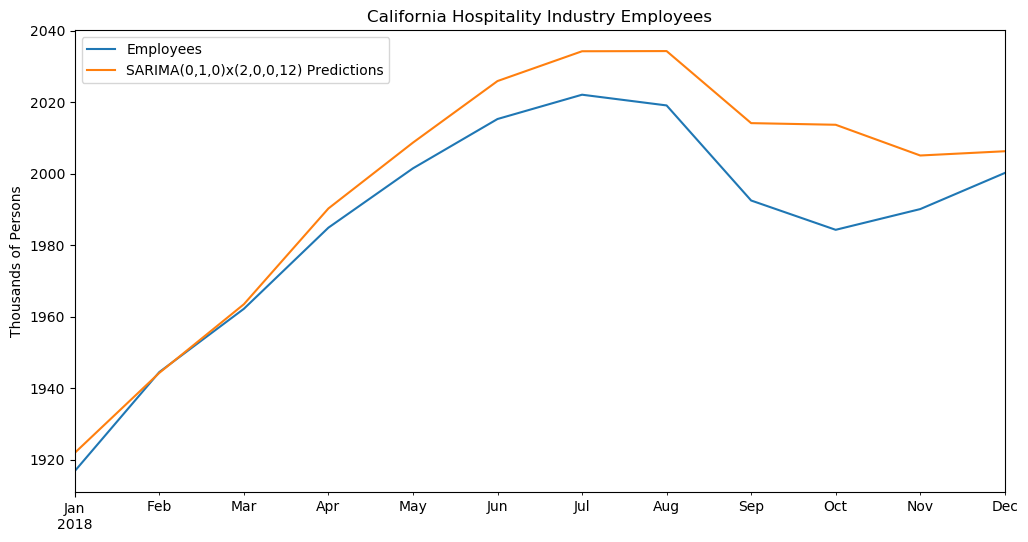

In [9]:
title = 'California Hospitality Industry Employees'
ylabel = 'Thousands of Persons'
xlabel = ''


ax = test['Employees'].plot(legend = True, figsize= (12,6), title = title)
predictions.plot(legend=True)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### 8. Evaluating the Model

In [10]:
err_mse = mean_squared_error(test['Employees'], predictions)
err_rmse = rmse(test['Employees'], predictions)
print(f'SARIMA(0,1,0)(2,0,0,12) MSE: {err_mse:.6f}')
print(f'SARIMA(0,1,0)(2,0,0,12) RMSE: {err_rmse:.6f}')

SARIMA(0,1,0)(2,0,0,12) MSE: 182.850657
SARIMA(0,1,0)(2,0,0,12) RMSE: 13.522228


### 9. Forecasting

In [11]:
model = SARIMAX(df['Employees'], order=(0,1,0), seasonal_order=(2,0,0,12))
results = model.fit()
forecast = results.predict(len(df), len(df)+11, typ='levels').rename('SARIMA(0,1,0)(2,0,0,12) Forecast')

### 10. Plotting the forecasted values vs original data

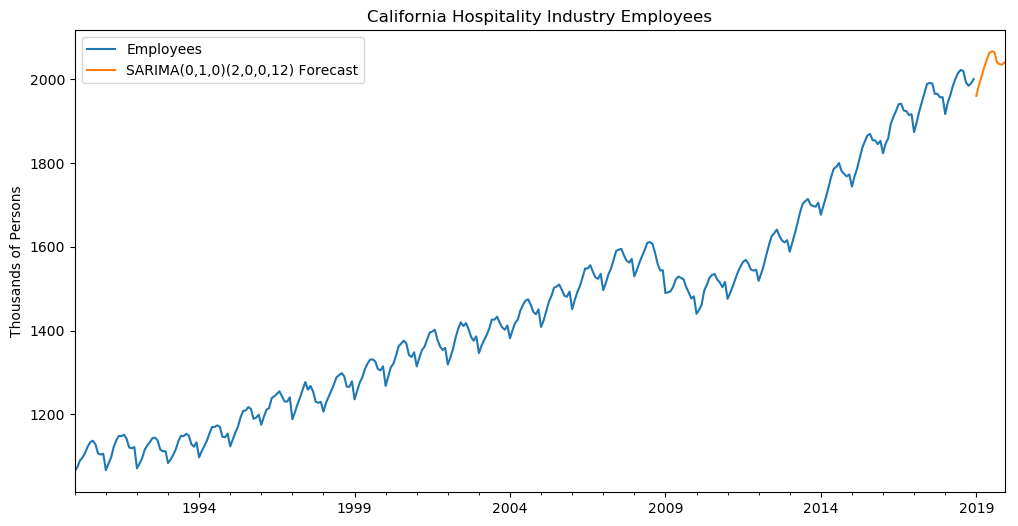

In [12]:
# DON'T WRITE HERE
title='California Hospitality Industry Employees'
ylabel='Thousands of Persons'
xlabel=''

ax = df['Employees'].plot(legend=True,figsize=(12,6),title=title)
forecast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

The forecasted data looks almost identical to real values (https://fred.stlouisfed.org/series/CALEIHN). I didn't used the full dataset since Covid-19 pandemic affected the data.